In [31]:
import torch
import torch.nn.functional as nnf
from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader
from torch.optim import SGD 
from torch.distributions import constraints
import torchvision as torchv
import torchvision.transforms as torchvt
from torchvision.datasets.mnist import MNIST
from torch import nn
from pyro.infer import SVI, TraceMeanField_ELBO
import pyro
from pyro import poutine
import pyro.optim as pyroopt
import pyro.distributions as dist
import pyro.contrib.bnn as bnn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions.utils import lazy_property
import math
from modules.config import read_config
import generate
import os
from modules.datageneration import load_data
import tyxe

In [15]:
BASE_DIR = "./tests/sanity_check"
PROFILE = "sinus-(10,20)-normaldelta"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [16]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-10k ======


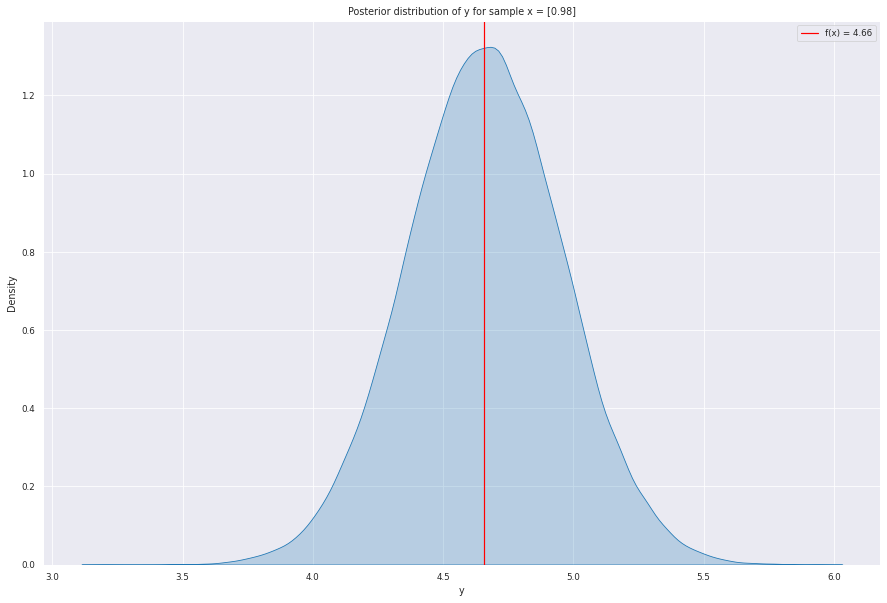

In [17]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [18]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

In [24]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=3)

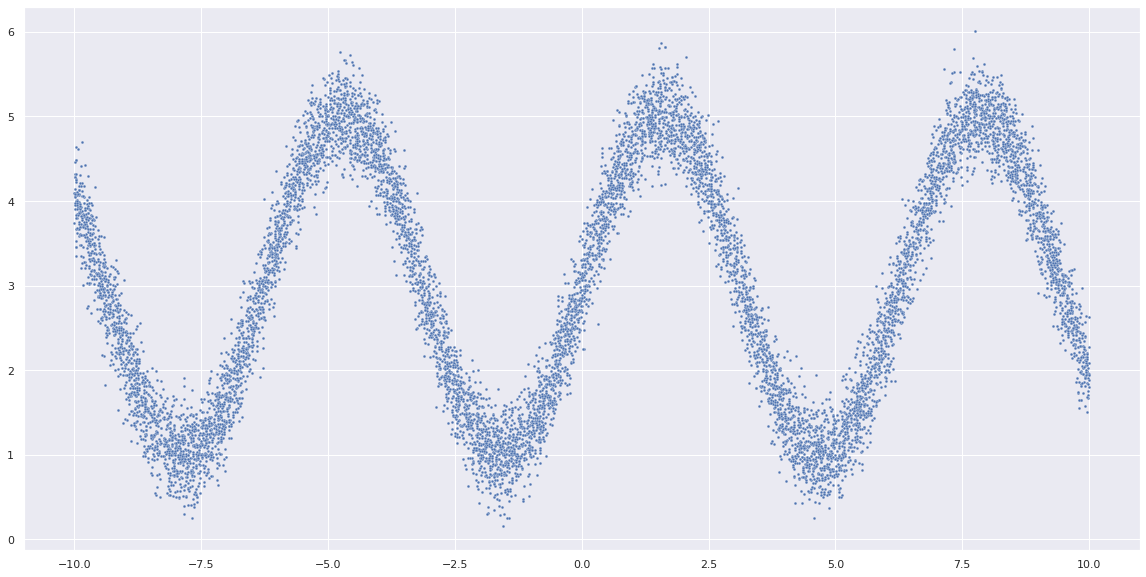

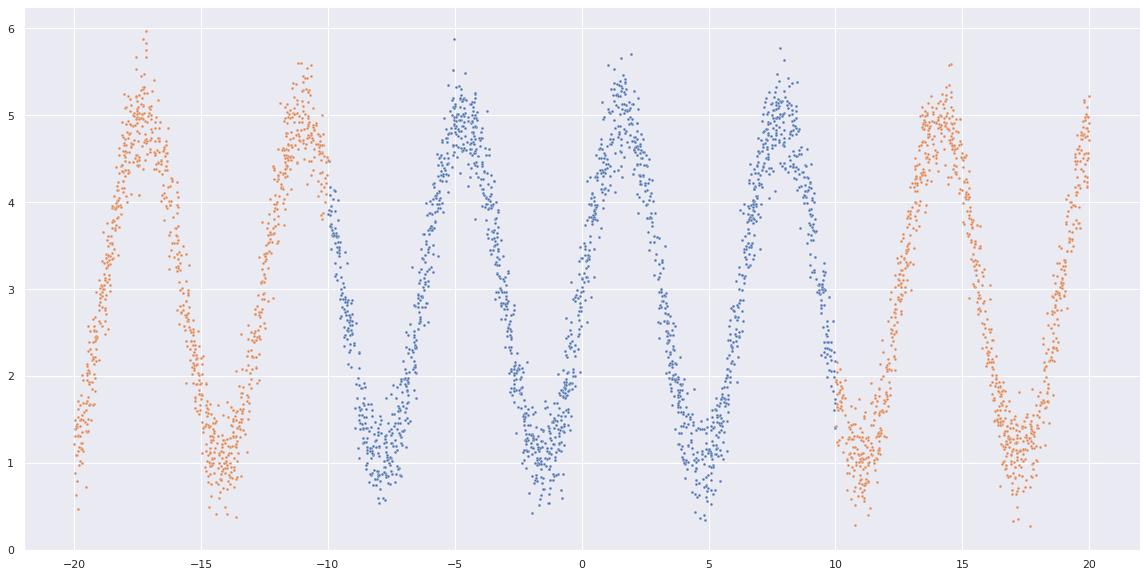

In [20]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_train.flatten(), y=y_train, s=8, ax=ax)
plt.show()
fig, ax = plt.subplots(1, 1)
sns.scatterplot(x=x_test_in_domain.flatten(), y=y_test_in_domain, s=8, ax=ax)
sns.scatterplot(x=x_test_out_domain.flatten(), y=y_test_out_domain, s=8, ax=ax)
plt.show()


In [33]:
net = nn.Sequential(nn.Linear(1, 32), nn.ReLU(), nn.Linear(32, 32), nn.ReLU(), nn.Linear(32, 1))
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
likelihood = tyxe.likelihoods.HomoskedasticGaussian(dataset_size=len(train_dataset), scale=0.1)
inference = tyxe.guides.AutoNormal
bnn = tyxe.VariationalBNN(net, prior, likelihood, inference)


In [34]:
optim = pyro.optim.Adam({"lr": 1e-3})
bnn.fit(train_dataloader, optim, 50)

In [48]:
pred = bnn.predict(x_test, num_predictions=10)

In [53]:
pred[2].shape

IndexError: tuple index out of range